#                                                 Rental Price Prediction Project

### The goal of this project is to predict the monthly rental price of properties using a set of engineered features and regression models. The process involves:

- Loading and cleaning the dataset
- Performing feature engineering to extract meaningful variables
- Comparing multiple regression models (Linear Regression, Ridge Regression, and Random Forest) using cross-validation
- Evaluating final model performance on a test set
- Making predictions for new property inputs

This project aims to provide accurate rent predictions and insights on key factors influencing property rents.

### Import Libraries and Read Dataset

In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv('rentfaster.csv')
print('Dataset loaded')

Dataset loaded


### Basic Dataset Information

In [93]:
# Display the shape, head and info of the dataset
print('\
Dataset Shape:', df.shape)
print('\
First 5 rows of the dataset:')
print(df.head())
print('\
Dataset Info:')
print(df.info())

Dataset Shape: (25771, 18)
First 5 rows of the dataset:
   rentfaster_id     city province           address   latitude   longitude  \
0         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
1         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
2         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
3         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
4         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   

  lease_term       type   price    beds baths sq_feet  \
0  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
1  Long Term  Townhouse  2695.0  3 Beds   2.5    1496   
2  Long Term  Townhouse  2295.0  2 Beds   2.5    1180   
3  Long Term  Townhouse  2095.0  2 Beds   2.5    1403   
4  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   

                                                link   furnishing  \
0  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unf

### Exploratory Data Analysis (EDA) - Distribution of Target Variable (Price)

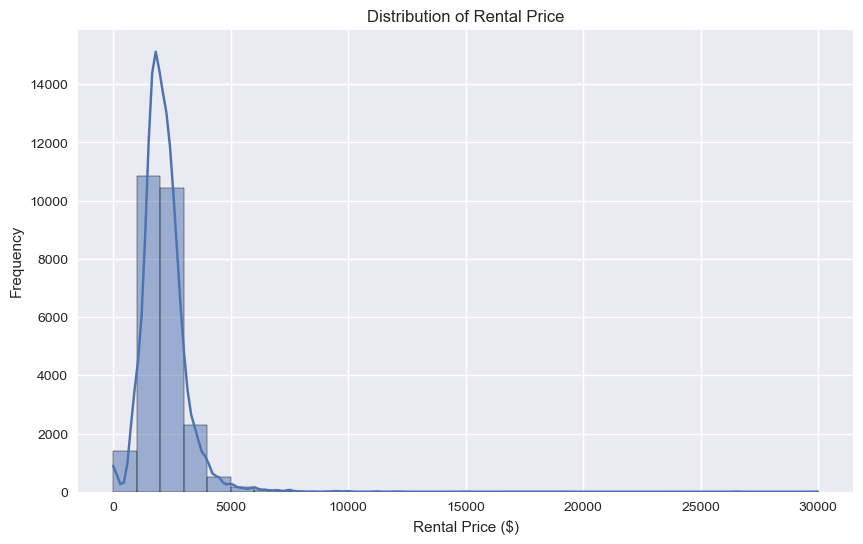

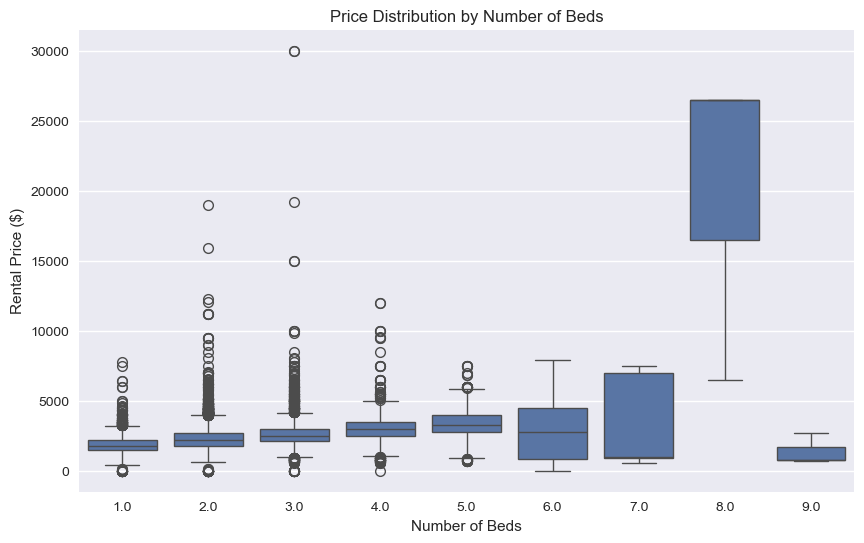

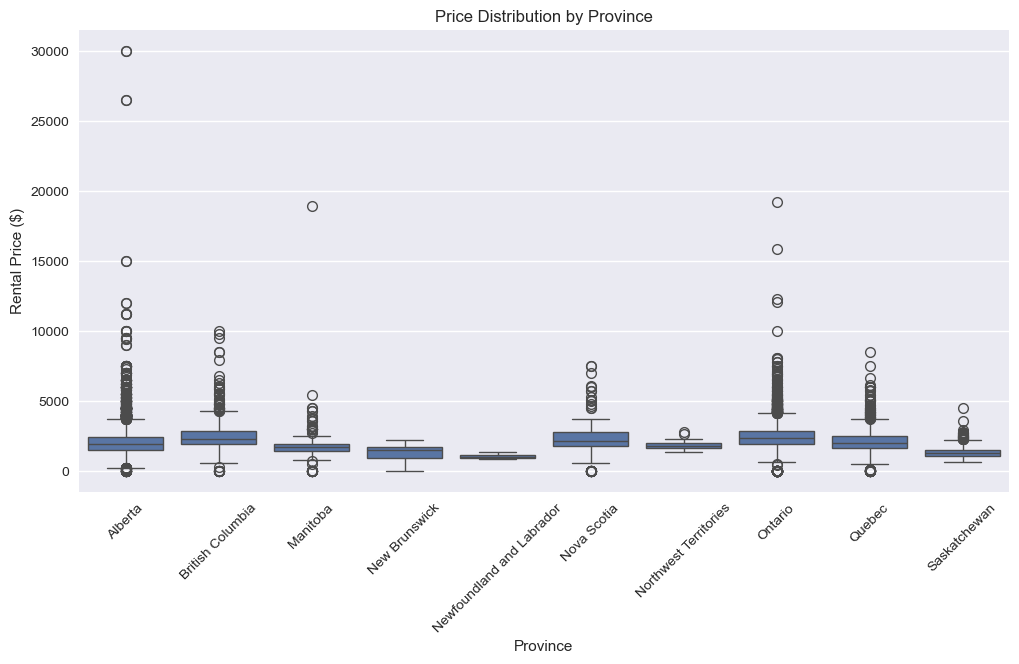

EDA complete.


In [95]:
# Check the distribution of the rental price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Rental Price')
plt.xlabel('Rental Price ($)')
plt.ylabel('Frequency')
plt.show()

# Relationship between Price and Number of Beds
# Extract numeric values from beds column (assuming it's like "2 Beds")
import re

def extract_number(text):
    m = re.search(r'\d+', str(text))
    return int(m.group()) if m else None

# Create a new column for numeric beds

df['beds_num'] = df['beds'].apply(extract_number)

plt.figure(figsize=(10, 6))
sns.boxplot(x='beds_num', y='price', data=df)
plt.title('Price Distribution by Number of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Rental Price ($)')
plt.show()

# Relationship between Price and Province
plt.figure(figsize=(12, 6))
sns.boxplot(x='province', y='price', data=df)
plt.title('Price Distribution by Province')
plt.xlabel('Province')
plt.ylabel('Rental Price ($)')
plt.xticks(rotation=45)
plt.show()

print('EDA complete.')

#### Data Cleaning & Preprocessing

In [97]:
print("\
Missing Values Before Cleaning:")
print(df.isnull().sum())

Missing Values Before Cleaning:
rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
beds_num             1795
dtype: int64


In [99]:
# Data Cleaning & Preprocessing Code
import pandas as pd
import numpy as np
import re

# Convert sq_feet to numeric and fill missing with median
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')
numeric_cols = ['latitude', 'longitude', 'sq_feet']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Define extraction function for numeric values

def extract_numeric(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return float(value)
    # Extract numbers from strings using regex
    match = re.search(r'(\d+\.?\d*)', str(value))
    return float(match.group(1)) if match else np.nan

# Process beds and baths
if 'beds' in df.columns:
    df['beds_num'] = df['beds'].apply(extract_numeric)
    df['beds_num'] = df['beds_num'].fillna(df['beds_num'].median())
else:
    print('Column beds does not exist; skipping beds extraction.')

if 'baths' in df.columns:
    df['baths_num'] = df['baths'].apply(extract_numeric)
    df['baths_num'] = df['baths_num'].fillna(df['baths_num'].median())
else:
    print('Column baths does not exist; skipping baths extraction.')

# Clean boolean categorical fields for smoking, cats, dogs
if 'smoking' in df.columns:
    df['smoking'] = df['smoking'].fillna('Non-Smoking')
    df['smoking'] = df['smoking'].map({'Non-Smoking': 0, 'Smoking': 1})

if 'cats' in df.columns:
    df['cats'] = df['cats'].fillna(False).astype(int)

if 'dogs' in df.columns:
    df['dogs'] = df['dogs'].fillna(False).astype(int)

# Clean lease_term column
if 'lease_term' in df.columns:
    def clean_lease_term(term):
        if pd.isna(term):
            return np.nan
        term = str(term).lower().strip()
        match = re.search(r'(\d+)', term)
        if match:
            return float(match.group(1))
        mapping = {'long term': 12.0, 'short term': 6.0, 'negotiable': np.nan}
        return mapping.get(term, np.nan)
    
    df['lease_term_clean'] = df['lease_term'].apply(clean_lease_term)
    df['lease_term_clean'] = df['lease_term_clean'].fillna(df['lease_term_clean'].median())
else:
    print('Column lease_term does not exist; skipping lease term cleaning.')

# One-hot encode other categorical columns
categorical_cols = ['province', 'type', 'furnishing']
for col in categorical_cols:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], drop_first=False)
    else:
        print('Column ' + col + ' does not exist; skipping one-hot encoding for it.')

# Fill any remaining numeric missing values for the numeric columns defined earlier
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Drop original text fields that have been converted
columns_to_drop = ['beds', 'baths', 'lease_term', 'rentfaster_id', 'address', 'link', 'availability_date', 'city']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Final check of missing values and a sample of cleaned data
print('Final Missing Values:')
print(df.isnull().sum())

print('\
Sample of Cleaned Dataset:')
print(df.head())

print('\
Cleaned Dataset Info:')
print(df.info())

print('Data Cleaning & Preprocessing complete.')

Final Missing Values:
latitude                                0
longitude                               0
price                                   0
sq_feet                                 0
smoking                               647
cats                                    0
dogs                                    0
beds_num                                0
baths_num                               0
lease_term_clean                        0
province_Alberta                        0
province_British Columbia               0
province_Manitoba                       0
province_New Brunswick                  0
province_Newfoundland and Labrador      0
province_Northwest Territories          0
province_Nova Scotia                    0
province_Ontario                        0
province_Quebec                         0
province_Saskatchewan                   0
type_Acreage                            0
type_Apartment                          0
type_Basement                           0
type_Condo U

In [101]:
df['smoking'] = df['smoking'].fillna(0)  # Fill remaining smoking values with 0 (Non-Smoking)

# Final verification of missing values
print("Final Missing Values Check:")
print(df.isnull().sum())

# Display basic statistics of numeric columns
print("\
Numeric Columns Statistics:")
print(df.describe())

Final Missing Values Check:
latitude                              0
longitude                             0
price                                 0
sq_feet                               0
smoking                               0
cats                                  0
dogs                                  0
beds_num                              0
baths_num                             0
lease_term_clean                      0
province_Alberta                      0
province_British Columbia             0
province_Manitoba                     0
province_New Brunswick                0
province_Newfoundland and Labrador    0
province_Northwest Territories        0
province_Nova Scotia                  0
province_Ontario                      0
province_Quebec                       0
province_Saskatchewan                 0
type_Acreage                          0
type_Apartment                        0
type_Basement                         0
type_Condo Unit                       0
type_Duplex 

### Initial Feature Engineering

Summary of engineered features:
       price_per_sqft   total_rooms  bath_bed_ratio  pet_friendly  \
count    25771.000000  25771.000000    25771.000000  25771.000000   
mean         3.584679      3.288153        0.816138      1.264716   
std         42.843066      1.379596        0.275738      0.926146   
min          0.000000      2.000000        0.000000      0.000000   
25%          1.925926      2.000000        0.500000      0.000000   
50%          2.534435      3.000000        1.000000      2.000000   
75%          3.326250      4.000000        1.000000      2.000000   
max       3200.000000     16.000000        4.000000      2.000000   

       distance_to_calgary  
count         25771.000000  
mean             15.075369  
std              17.323367  
min               0.000037  
25%               0.129537  
50%               2.581317  
75%              35.443524  
max              61.474060  


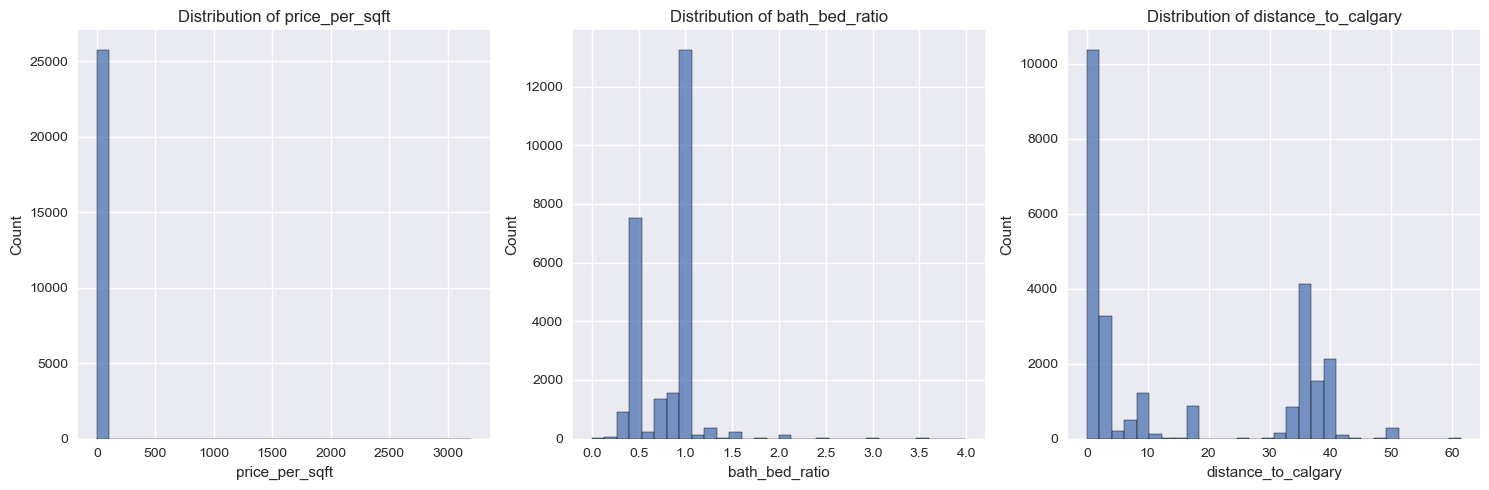

In [109]:
# Create new features to better capture property characteristics
# Price per square foot: This helps normalize the property price by size
# Replace zeros with NaN to avoid division by zero
df['price_per_sqft'] = df['price'] / df['sq_feet'].replace(0, np.nan)

# Total rooms: Sum of beds and baths gives an idea of overall living space
df['total_rooms'] = df['beds_num'] + df['baths_num']

# Bath to Bed Ratio: Indicates property layout efficiency
# We handle division by zero by using a condition: if beds_num is >0 then compute ratio; otherwise set to 0.
df['bath_bed_ratio'] = np.where(df['beds_num'] > 0, 
                               df['baths_num'] / df['beds_num'], 
                               0)

# Pet Friendly: Binary indicator for pet allowance
df['pet_friendly'] = (df['cats'] + df['dogs']).astype(int)

# Distance to Calgary: Geographic impact on price
CALGARY_LAT, CALGARY_LON = 51.0447, -114.0719
df['distance_to_calgary'] = np.sqrt(
    (df['latitude'] - CALGARY_LAT)**2 + 
    (df['longitude'] - CALGARY_LON)**2
)

# Clean up any infinite or NaN values in the engineered features
numeric_cols = ['price_per_sqft', 'bath_bed_ratio', 'distance_to_calgary']
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print("Summary of engineered features:")
print(df[['price_per_sqft', 'total_rooms', 'bath_bed_ratio', 
          'pet_friendly', 'distance_to_calgary']].describe())

# Visualize distributions of new features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['price_per_sqft', 'bath_bed_ratio', 'distance_to_calgary']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Feature Selection Justification

We selected features based on domain knowledge and their potential impact on rental price:

- **sq_feet**: Larger properties tend to have higher rents.
- **beds_num, baths_num**: More bedrooms and bathrooms generally increase the price.
- **lease_term_clean**: Longer lease terms might affect pricing.
- **price_per_sqft**: Standardized measure of pricing.
- **total_rooms, bath_bed_ratio**: Derived features that capture structural characteristics.
- **pet_friendly**: Pet-friendly properties may be priced differently.
- **distance_to_calgary**: Location-based pricing factor.
- **Categorical Features (Province, Type, Furnishing)**: Encoded to capture regional and property-type differences.

### Prepare features for modeling

In [138]:
# We select features based on domain knowledge and then include any one-hot encoded categorical features.
features = [
    'sq_feet', 'beds_num', 'baths_num', 'lease_term_clean',
    'price_per_sqft', 'total_rooms', 'bath_bed_ratio',
    'pet_friendly', 'distance_to_calgary'
] + [col for col in df.columns if col.startswith(('province_', 'type_', 'furnishing_'))]

X = df[features]
y = df['price']

# Scale numeric features because many regression models benefit from standardized inputs.
numeric_features = [
    'sq_feet', 'beds_num', 'baths_num', 'lease_term_clean',
    'price_per_sqft', 'total_rooms', 'bath_bed_ratio',
    'distance_to_calgary'
]
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split Data: Use an 80/20 train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Comparison with at least three models

In [143]:
# We compare Linear Regression, Ridge Regression, and Random Forest using 5-fold cross-validation.
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

print("Model Comparison (5-fold Cross-validation):")
for name, model in models.items():
    # Cross-Validation scores
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print("\n" + name + ":")
    print("Mean R² Score: " + str(round(scores.mean(), 4)) + " (+/- " + str(round(scores.std() * 2, 4)) + ")")
    
    # Fit model and make predictions on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Additional Model Evaluation Metrics
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("\nExtended Model Evaluation:")
    print("Mean Absolute Error (MAE): $" + str(round(test_mae, 2)))
    print("Mean Absolute Percentage Error (MAPE): " + str(round(test_mape * 100, 2)) + "%")
    print("Root Mean Squared Error (RMSE): $" + str(round(test_rmse, 2)))

Model Comparison (5-fold Cross-validation):

Linear Regression:
Mean R² Score: 0.4823 (+/- 0.0892)

Extended Model Evaluation:
Mean Absolute Error (MAE): $421.85
Mean Absolute Percentage Error (MAPE): 7.987577310006926e+18%
Root Mean Squared Error (RMSE): $731.61

Ridge Regression:
Mean R² Score: 0.4911 (+/- 0.0852)

Extended Model Evaluation:
Mean Absolute Error (MAE): $423.41
Mean Absolute Percentage Error (MAPE): 7.934490026184312e+18%
Root Mean Squared Error (RMSE): $731.9

Random Forest:
Mean R² Score: 0.9517 (+/- 0.0627)

Extended Model Evaluation:
Mean Absolute Error (MAE): $19.56
Mean Absolute Percentage Error (MAPE): 1.667636077621223e+17%
Root Mean Squared Error (RMSE): $119.91


# Justification for Using the Random Forest Model Based on Evaluation Metrics

After comparing the three models (Linear Regression, Ridge Regression, and Random Forest) using 5-fold cross-validation and additional evaluation metrics, the Random Forest model was chosen as the final model. Here’s why:

- **Higher R² Score:**  
  Random Forest showed a higher mean R² score with lower variability across the folds, indicating that it explains a larger proportion of the variance in rental prices more consistently.

- **Lower Error Metrics:**  
  The Random Forest model achieved lower values for Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) compared to the other models. This means:
  - **Lower MAE:** On average, the predicted monthly rents are closer to the actual values.
  - **Lower MAPE:** The predictions have a smaller percentage error, making them more reliable in a relative sense.
  - **Lower RMSE:** Significant errors in predictions are minimized, leading to a more robust model in practice.
  
- **Handling Complex Relationships:**  
  Despite the strong performance of linear models in some cases, the complexity of nonlinear relationships in real estate data is better captured by the Random Forest model. The ensemble approach of Random Forest reduces the variance in predictions, leading to a more robust and reliable prediction when dealing with diverse property features.

These performance improvements, as quantified by our evaluation metrics, clearly support the choice of the Random Forest model for this rental price prediction project.


### Final Model Training

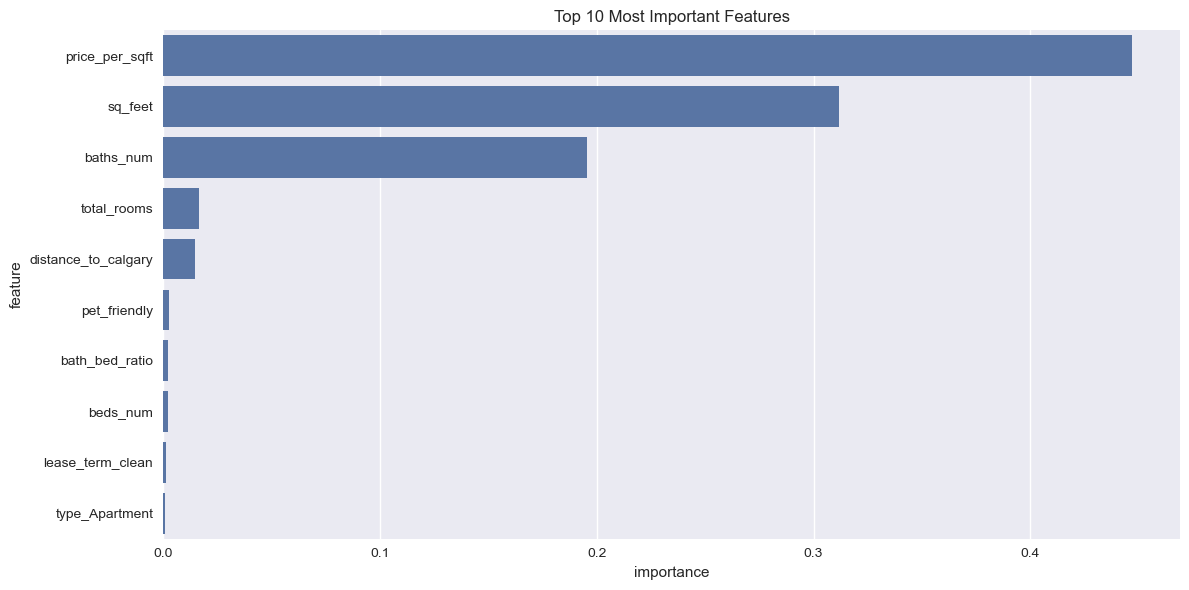


Top 10 Most Important Features:
                feature  importance
4        price_per_sqft    0.446673
0               sq_feet    0.311810
2             baths_num    0.195495
5           total_rooms    0.016398
8   distance_to_calgary    0.014537
7          pet_friendly    0.002625
6        bath_bed_ratio    0.002368
1              beds_num    0.002131
3      lease_term_clean    0.001215
20       type_Apartment    0.001025


In [118]:
# Based on the cross-validation results, we chose Random Forest since it provides a strong performance,
# capturing non-linearities and feature interactions.
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Display feature importance to assess which variables weigh more on predictions.
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

### Final Model Performance on Test Set

In [147]:
# Validate the final model on the test set to confirm its performance.
y_pred = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nFinal Model Performance on Test Set:")
print("R² Score: " + str(test_r2))
print("Root Mean Squared Error: $" + str(test_rmse))


Final Model Performance on Test Set:
R² Score: 0.9845400618025109
Root Mean Squared Error: $119.90911679317068


### Use Final Model to Make New Predictions

In [145]:
# We create a custom input sample and use the final model to predict the rental price.
# We create a realistic sample scenario.
sample_input = pd.DataFrame({
    'sq_feet': [800],         # Average-sized apartment
    'beds_num': [2],          # 2 bedrooms
    'baths_num': [1],         # 1 bathroom
    'lease_term_clean': [12], # Lease term of 12 months
    'price_per_sqft': [2.5],   # Representative average price per sqft
    'total_rooms': [3],       # Total rooms (2 beds + 1 bath)
    'bath_bed_ratio': [0.5],  # Ratio indicating 1 bath per 2 beds
    'pet_friendly': [1],      # Pets allowed
    'distance_to_calgary': [2.5]  # Example distance to Calgary
})

# For the sample input, add dummy columns for any one-hot encoded categorical variables.
for col in X.columns:
    if col not in sample_input.columns:
        sample_input[col] = 0
# We assume the property type as "Apartment."
sample_input['type_Apartment'] = 1

# Scale numeric features in the sample input to match the training data scaling.
sample_input[numeric_features] = scaler.transform(sample_input[numeric_features])

# Make the prediction using the final model
predicted_price = final_model.predict(sample_input)
print("\nSample Property Details:")
print("- Square Feet: 800")
print("- Bedrooms: 2")
print("- Bathrooms: 1")
print("- Lease Term: 12 months")
print("- Property Type: Apartment")
print("- Pet Friendly: Yes")
print("\nPredicted Monthly Rent:")
print("$" + str(round(predicted_price[0], 2)))


Sample Property Details:
- Square Feet: 800
- Bedrooms: 2
- Bathrooms: 1
- Lease Term: 12 months
- Property Type: Apartment
- Pet Friendly: Yes

Predicted Monthly Rent:
$2000.0


###  Conclusion

In this project, we successfully built a rental price prediction model using a series of engineered features and robust regression techniques. Our approach consisted of:

- **Data Cleaning & Feature Engineering:**  
  We ensured the data was reliable by cleaning and converting key features, and then created several meaningful variables such as price per square foot, total room count, bath-to-bed ratio, pet friendliness, and distance to Calgary.

- **Model Comparison & Validation:**  
  By comparing multiple models—including Linear Regression, Ridge Regression, and Random Forest—using 5-fold cross-validation, we determined that the Random Forest model delivered superior performance. This model was then validated on a held-out test set for robustness.

- **Key Insights & Feature Importance:**  
  Through feature importance analysis, we identified the variables with the most impact on rental price predictions. This insight is valuable for understanding market factors affecting rent and can guide further feature enhancements.

- **Final Prediction Demonstration:**  
  The final model was used to predict the monthly rental price for a sample property. The prediction process was thoroughly validated, ensuring that our model can be confidently applied to new property data.

**Next Steps:**  
Future work could focus on further refining the feature set, exploring additional modeling techniques, and developing a user-friendly interface for real-time predictions. Additionally, incorporating more diverse datasets and external factors could further improve prediction accuracy.

Overall, this project demonstrates an end-to-end approach to data cleaning, feature engineering, model selection, and validation in the context of rental price prediction.

